## Libaries

In [1]:

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
#Libaries for calculation and processing
from einops import rearrange, repeat
import math
from math import sqrt
from math import ceil
import numpy as np
from sklearn.preprocessing import StandardScaler
#libaries for data importng, formating and handling 
import pandas as pd
#For analysis and plotting
import matplotlib.pyplot as plt
import seaborn as sns
#others
import os
import time
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from data.Dataset import *
from model.Crossformer import *
from exp.ExpFish import *

## Hyperparameters

In [2]:
#DATASET 
ROOT_PATH = "Data/fishes/fish02/s1/"
DATA_PATH = "df_timeseries_red_clusters_s1.csv"
TRAIN_FLAG = "train"
VAL_FLAG = "val"
TEST_FLAG = "test"
SIZE=[100,25,25] #[seq_len, label_len, pred_len]
SCALE = True
SCALE_STATISTIC = True
DATA_SPLIT = [1, 0, 0.0]  # Train, Val, TEST
STRIDE = 1
#DATALOADER 
BATCH_SIZE = 10
SHUFFLE_FLAG = False
NUM_WORKSES = 0
DROP_LAST = False

#MODEL 
DATA_DIM = 2 # number of clusers
IN_LEN   = SIZE[0]
OUT_LEN  = SIZE[2]
SEG_LEN  = 25
WIN_SIZE = 1
FACTOR   = 2
D_MODEL  = 256 
D_FF     = 512
N_HEADS  = 1
E_LAYERS = 1
DROPOUT  = 0.0
BASELINE = False

#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#OPTIMIZER
LR = 0.0001

#TRAINING 
NUM_EPOCHS = 2


# Set a seed value
seed_value= 123

# 1. Set `torch` seed for GPU/CPU random number generation
torch.manual_seed(seed_value)


# Experiment synthetic Sinus



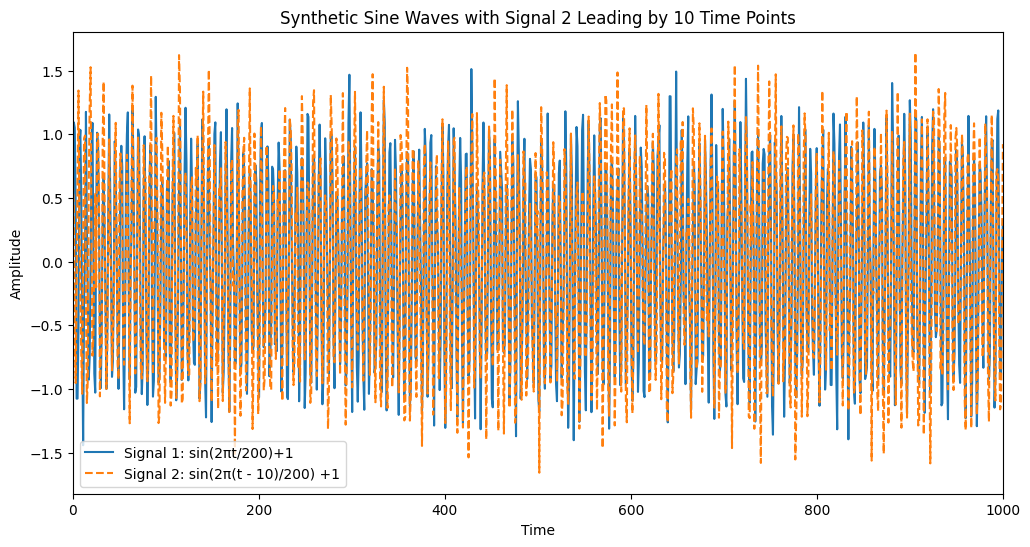

In [3]:
# Generate synthetic data with adjustments
t = np.linspace(0, 1000, 1000)  # Time variable from 0 to 1000
signal_1 = np.sin(2 * np.pi * t / 100) +1  # First sine wave
signal_2 = np.sin(2 * np.pi * (t - 25) / 100) +1 # Second sine wave, shifted to be ahead by 10 time points


# Generate a simple pattern (e.g., sine wave) and add noise to create two related, non-deterministic signals
t = np.linspace(0, 1000, 1000)  # Time vector
signal_1 = np.sin(t) + np.random.normal(0, 0.2, t.shape)  # Signal 1 with noise
signal_2 = np.roll(signal_1, 25) + np.random.normal(0, 0.2, t.shape)  # Signal 2, lagged version of signal 1 with noise


# Plot the adjusted synthetic signals
plt.figure(figsize=(12, 6))
plt.plot(t, signal_1, label='Signal 1: sin(2πt/200)+1')
plt.plot(t, signal_2, label='Signal 2: sin(2π(t - 10)/200) +1', linestyle='--')
plt.legend()
plt.title('Synthetic Sine Waves with Signal 2 Leading by 10 Time Points')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim(0, 1000)  # Limiting x-axis to show the leading effect more clearly
plt.show()



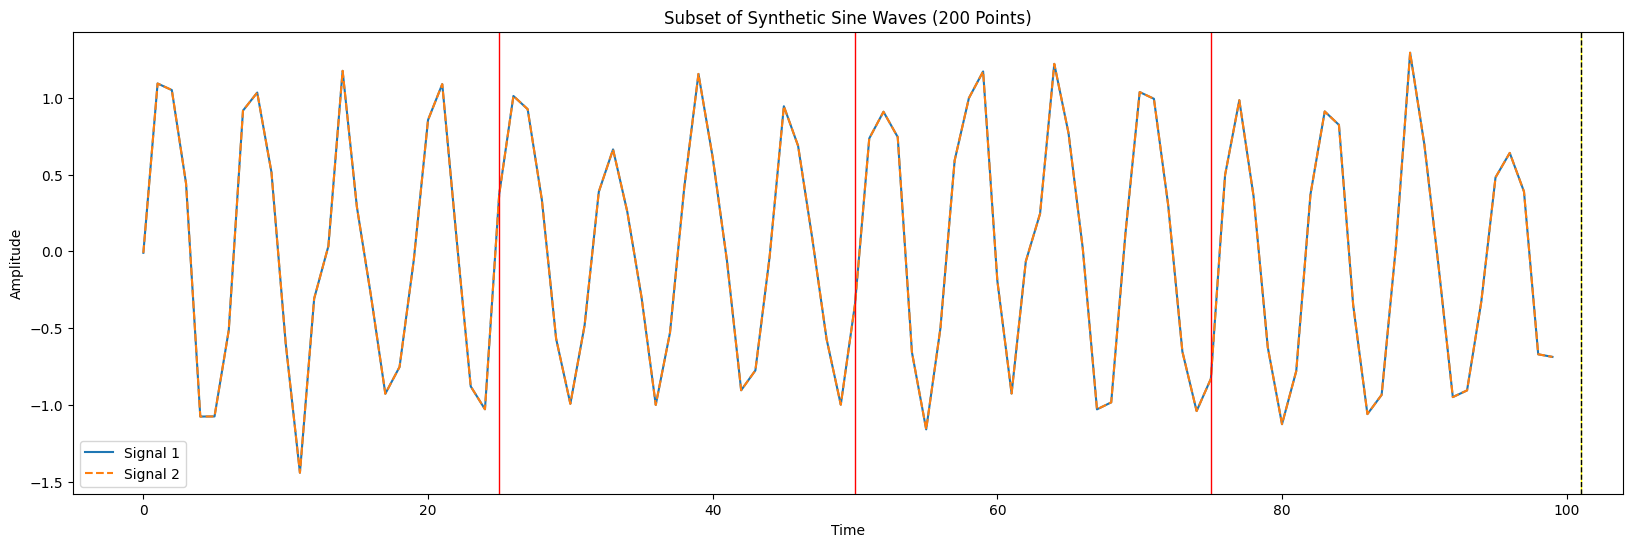

,Signal_1,Signal_2
0,-0.009465,-0.009465
1,1.093617,1.093617
2,1.050923,1.050923
3,0.441937,0.441937
4,-1.076347,-1.076347
...,...,...
195,0.450753,0.450753
196,0.759020,0.759020
197,0.638120,0.638120
198,-0.236415,-0.236415


In [4]:

# Creating a pandas DataFrame to store the synthetic data
df = pd.DataFrame({
    'Signal_1': signal_1,
    'Signal_2': signal_1
})

# Display the first few rows of the DataFrame
df.head()
len(df)


# Load 200 points for each of the signals from the DataFrame
df_subset = df.iloc[:100]

# Plot the subset of data for both signals
plt.figure(figsize=(20, 6))
plt.plot( df_subset['Signal_1'], label='Signal 1')
plt.plot( df_subset['Signal_2'], label='Signal 2', linestyle='--')
for x in range(SEG_LEN, SIZE[0], SEG_LEN):
    plt.axvline(x=x, color='red', linestyle='-', linewidth=1)
 
plt.axvline(x=101, color='yellow', linestyle='-', linewidth=1)   
plt.axvline(x=101, color='black', linestyle='--', linewidth=1)   

plt.legend()
plt.title('Subset of Synthetic Sine Waves (200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
df.iloc[:200]


In [5]:
synth_data = Dataset_MTS_simplified(df_data=df,stride=STRIDE,size=SIZE,cols_target=[0,1])
data_loader_train_synth = DataLoader(
            synth_data,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )

synth_data.__len__()

876

In [6]:
model_synt = Crossformer(
    data_dim=DATA_DIM,
    in_len=IN_LEN,
    out_len=OUT_LEN,
    seg_len=SEG_LEN,
    win_size=WIN_SIZE,
    factor=FACTOR,
    d_model=D_MODEL,
    d_ff=D_MODEL,
    n_heads=N_HEADS,
    e_layers=E_LAYERS,
    dropout=DROPOUT,
    baseline=False,
    device=DEVICE
    
).float()

criterion = nn.MSELoss()
optimizer = optim.Adam(model_synt.parameters(), lr=LR)

## Train

In [7]:
exp = Expfish(model=model_synt,
               data_loader_train=data_loader_train_synth,
               data_loader_test=None,
               data_loader_val=None,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE
               
               )

model_synt = exp.train()







0,100
1,101
2,102
3,103
4,104
5,105
6,106
7,107
8,108
9,109
10,110
11,111
12,112
13,113
14,114
15,115
16,116
17,117
18,118
19,119
20,120
21,121
22,122
23,123
24,124
25,125
26,126
27,127
28,128
29,129


30,130
31,131
32,132
33,133
34,134
35,135
36,136
37,137
38,138
39,139
40,140
41,141
42,142
43,143
44,144
45,145
46,146
47,147
48,148
49,149
50,150
51,151
52,152
53,153
54,154
55,155
56,156
57,157
58,158
59,159
60,160
61,161
62,162
63,163
64,164
65,165
66,166
67,167
68,168
69,169
70,170
71,171
72,172
73,173
74,174
75,175
76,176
77,177
78,178
79,179
80,180
81,181
82,182
83,183
84,184
85,185
86,186
87,187
88,188
89,189
90,190
91,191
92,192
93,193
94,194
95,195
96,196
97,197
98,198
99,199
100,200
101,201
102,202
103,203
104,204
105,205
106,206
107,207
108,208
109,209
110,210
111,211
112,212
113,213
114,214
115,215
116,216
117,217
118,218
119,219
120,220
121,221
122,222
123,223
124,224
125,225
126,226
127,227
128,228
129,229
130,230
131,231
132,232
133,233
134,234
135,235
136,236
137,237
138,238
139,239
140,240
141,241
142,242
143,243
144,244
145,245
146,246
147,247
148,248
149,249
150,250
151,251
152,252
153,253
154,254
155,255
156,256
157,257
158,258
159,259
160,260
161,261
162,262
163,26

## Weights

In [39]:
tsa_layer = model_synt.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights = tsa_layer.get_attn()
tsa_l = model_synt.decoder.decode_layers[0]

dec_attn=tsa_l.get_attn()
dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
dec_attn[0]['dec_attnetion'].shape


torch.Size([20, 1, 1, 4])

In [40]:
len(tsa_layer_weights)

88

### Trying to create heat map over time



In [10]:
first_10_batches = tsa_layer_weights[0]
first_10_batches_att_a_b = first_10_batches['att-A-B']
first_10_batches_att_b_a = first_10_batches['att-B-A']

In [11]:
all_a_b = []
all_b_a = []

for batch_sets in tsa_layer_weights:
    a = torch.flatten(batch_sets['att-A-B'],start_dim=0,end_dim=1)
    b = torch.flatten(batch_sets['att-B-A'],start_dim=0,end_dim=1)
    for batch in a:
        all_a_b.append(batch) 
    for batch in b:
        all_b_a.append(batch) 

In [12]:
len(all_b_a)
len(all_a_b)

876

In [41]:
all_a_b

[tensor([[0.4161, 0.1854, 0.2766, 0.1219],
         [0.2022, 0.2250, 0.4505, 0.1223],
         [0.2918, 0.1625, 0.3214, 0.2243],
         [0.1595, 0.1284, 0.4400, 0.2722]]),
 tensor([[0.4520, 0.1511, 0.1885, 0.2084],
         [0.2285, 0.2113, 0.3848, 0.1754],
         [0.2942, 0.1225, 0.2556, 0.3278],
         [0.1765, 0.0830, 0.3503, 0.3902]]),
 tensor([[0.3928, 0.2781, 0.1039, 0.2252],
         [0.2268, 0.3308, 0.2466, 0.1958],
         [0.2701, 0.1971, 0.1483, 0.3845],
         [0.1710, 0.1108, 0.2043, 0.5138]]),
 tensor([[0.3422, 0.4288, 0.0749, 0.1540],
         [0.1815, 0.5059, 0.1620, 0.1506],
         [0.2738, 0.3176, 0.0924, 0.3162],
         [0.1681, 0.1983, 0.1493, 0.4843]]),
 tensor([[0.2964, 0.5093, 0.1001, 0.0942],
         [0.1566, 0.5601, 0.1849, 0.0984],
         [0.2562, 0.4661, 0.1028, 0.1749],
         [0.1548, 0.3462, 0.1783, 0.3207]]),
 tensor([[0.3959, 0.3379, 0.1745, 0.0917],
         [0.1527, 0.4513, 0.3025, 0.0934],
         [0.2852, 0.3322, 0.2181, 0.1645],
 

In [14]:
# Create a nested dictionary for bins within each 100-point segment, iterating with a stride of 1
import itertools
# Initialize an empty dictionary
segmented_bins_dict = {}

# Iterate over the 1000 points, 100 at a time with a stride of 1
for segment_start in range(0, 1000, 1):
    segment_end = segment_start + 99
    segment_key = f"{segment_start}-{segment_end}"  # Key for the segment
    bins_dict = {}  # Temporary dictionary to hold bins for this segment
    
    # Create bins within the current segment
    for bin_start in range(segment_start, segment_start+100, 25):
        bin_end = bin_start + 24
        bin_key = f"{bin_start}-{bin_end}"  # Create a string key for the bin
        bins_dict[bin_key] = []  # Initialize an empty list as the value for each bin
    
    # Add the bins dictionary to the segmented dictionary
    segmented_bins_dict[segment_key] = bins_dict



In [15]:
seg_dic = dict(itertools.islice(segmented_bins_dict.items(), 876))

In [16]:
seg_dic

{'0-99': {'0-24': [], '25-49': [], '50-74': [], '75-99': []},
 '1-100': {'1-25': [], '26-50': [], '51-75': [], '76-100': []},
 '2-101': {'2-26': [], '27-51': [], '52-76': [], '77-101': []},
 '3-102': {'3-27': [], '28-52': [], '53-77': [], '78-102': []},
 '4-103': {'4-28': [], '29-53': [], '54-78': [], '79-103': []},
 '5-104': {'5-29': [], '30-54': [], '55-79': [], '80-104': []},
 '6-105': {'6-30': [], '31-55': [], '56-80': [], '81-105': []},
 '7-106': {'7-31': [], '32-56': [], '57-81': [], '82-106': []},
 '8-107': {'8-32': [], '33-57': [], '58-82': [], '83-107': []},
 '9-108': {'9-33': [], '34-58': [], '59-83': [], '84-108': []},
 '10-109': {'10-34': [], '35-59': [], '60-84': [], '85-109': []},
 '11-110': {'11-35': [], '36-60': [], '61-85': [], '86-110': []},
 '12-111': {'12-36': [], '37-61': [], '62-86': [], '87-111': []},
 '13-112': {'13-37': [], '38-62': [], '63-87': [], '88-112': []},
 '14-113': {'14-38': [], '39-63': [], '64-88': [], '89-113': []},
 '15-114': {'15-39': [], '40-64'

In [17]:
seg_dict_a = seg_dic
seg_dict_b = seg_dic
seg_dict_a

{'0-99': {'0-24': [], '25-49': [], '50-74': [], '75-99': []},
 '1-100': {'1-25': [], '26-50': [], '51-75': [], '76-100': []},
 '2-101': {'2-26': [], '27-51': [], '52-76': [], '77-101': []},
 '3-102': {'3-27': [], '28-52': [], '53-77': [], '78-102': []},
 '4-103': {'4-28': [], '29-53': [], '54-78': [], '79-103': []},
 '5-104': {'5-29': [], '30-54': [], '55-79': [], '80-104': []},
 '6-105': {'6-30': [], '31-55': [], '56-80': [], '81-105': []},
 '7-106': {'7-31': [], '32-56': [], '57-81': [], '82-106': []},
 '8-107': {'8-32': [], '33-57': [], '58-82': [], '83-107': []},
 '9-108': {'9-33': [], '34-58': [], '59-83': [], '84-108': []},
 '10-109': {'10-34': [], '35-59': [], '60-84': [], '85-109': []},
 '11-110': {'11-35': [], '36-60': [], '61-85': [], '86-110': []},
 '12-111': {'12-36': [], '37-61': [], '62-86': [], '87-111': []},
 '13-112': {'13-37': [], '38-62': [], '63-87': [], '88-112': []},
 '14-113': {'14-38': [], '39-63': [], '64-88': [], '89-113': []},
 '15-114': {'15-39': [], '40-64'

In [18]:
n = np.array(all_a_b)
m = np.array(all_b_a)


In [19]:
i = 0
for outer_key, inner_dict in seg_dict_a.items():
    j =0
    for inner_key in inner_dict.keys():
        inner_dict[inner_key] = n[i][j]
        j+=1
    i+=1    

In [20]:
i = 0
for outer_key, inner_dict in seg_dict_b.items():
    j =0
    for inner_key in inner_dict.keys():
        inner_dict[inner_key] = m[i][j]
        j+=1
    i+=1 

In [21]:
seg_dict_a

{'0-99': {'0-24': array([0.3820548 , 0.13215788, 0.33123806, 0.15454923], dtype=float32),
  '25-49': array([0.27191406, 0.23487294, 0.2944872 , 0.19872579], dtype=float32),
  '50-74': array([0.18960123, 0.21983856, 0.27230072, 0.3182595 ], dtype=float32),
  '75-99': array([0.15758276, 0.11260826, 0.35842323, 0.37138575], dtype=float32)},
 '1-100': {'1-25': array([0.3961448 , 0.15339683, 0.2635941 , 0.18686423], dtype=float32),
  '26-50': array([0.28062892, 0.30051768, 0.23255365, 0.18629979], dtype=float32),
  '51-75': array([0.16140878, 0.2524499 , 0.22375178, 0.36238956], dtype=float32),
  '76-100': array([0.18131265, 0.11693237, 0.29155907, 0.41019586], dtype=float32)},
 '2-101': {'2-26': array([0.35807404, 0.2499142 , 0.20325442, 0.18875729], dtype=float32),
  '27-51': array([0.28528252, 0.41017565, 0.16690695, 0.13763483], dtype=float32),
  '52-76': array([0.13464779, 0.3862776 , 0.15853797, 0.32053673], dtype=float32),
  '77-101': array([0.1606813 , 0.16890538, 0.22644639, 0.4439

In [22]:
import numpy as np

# Example input dictionary
seg_dict_a_new = seg_dict_a


# Transforming the structure with conditional inner keys
for segment_key, patches in seg_dict_a_new.items():
    patch_keys = list(patches.keys())  # List of patch keys for indexing
    num_patches = len(patch_keys)  # Total number of patches
    for i, patch_key in enumerate(patch_keys):
        # Initialize the new dictionary for each patch
        new_dict = {}
        # Determine which keys to include based on patch position
        key_offsets = range(max(-3, -i), min(4, num_patches - i))  # Adjust the range based on patch position
        
        for j in key_offsets:  # Only include keys within the valid range
            if j == 0:
                new_key = 'synch'
            else:
                new_key = f'{j}-patch'
            new_dict[new_key] = None  # Assign None to each valid key
            
        # Assign the new dictionary to the current patch
        seg_dict_a_new[segment_key][patch_key] = new_dict

# Example of how to check the transformed structure
seg_dict_a_new



{'0-99': {'0-24': {'synch': None,
   '1-patch': None,
   '2-patch': None,
   '3-patch': None},
  '25-49': {'-1-patch': None, 'synch': None, '1-patch': None, '2-patch': None},
  '50-74': {'-2-patch': None,
   '-1-patch': None,
   'synch': None,
   '1-patch': None},
  '75-99': {'-3-patch': None,
   '-2-patch': None,
   '-1-patch': None,
   'synch': None}},
 '1-100': {'1-25': {'synch': None,
   '1-patch': None,
   '2-patch': None,
   '3-patch': None},
  '26-50': {'-1-patch': None, 'synch': None, '1-patch': None, '2-patch': None},
  '51-75': {'-2-patch': None,
   '-1-patch': None,
   'synch': None,
   '1-patch': None},
  '76-100': {'-3-patch': None,
   '-2-patch': None,
   '-1-patch': None,
   'synch': None}},
 '2-101': {'2-26': {'synch': None,
   '1-patch': None,
   '2-patch': None,
   '3-patch': None},
  '27-51': {'-1-patch': None, 'synch': None, '1-patch': None, '2-patch': None},
  '52-76': {'-2-patch': None,
   '-1-patch': None,
   'synch': None,
   '1-patch': None},
  '77-101': {'-3-p

In [23]:
# Example input dictionary
seg_dict_b_new = seg_dict_b


# Transforming the structure with conditional inner keys
for segment_key, patches in seg_dict_b_new.items():
    patch_keys = list(patches.keys())  # List of patch keys for indexing
    num_patches = len(patch_keys)  # Total number of patches
    for i, patch_key in enumerate(patch_keys):
        # Initialize the new dictionary for each patch
        new_dict = {}
        # Determine which keys to include based on patch position
        key_offsets = range(max(-3, -i), min(4, num_patches - i))  # Adjust the range based on patch position
        
        for j in key_offsets:  # Only include keys within the valid range
            if j == 0:
                new_key = 'synch'
            else:
                new_key = f'{j}-patch'
            new_dict[new_key] = None  # Assign None to each valid key
            
        # Assign the new dictionary to the current patch
        seg_dict_b_new[segment_key][patch_key] = new_dict

# Example of how to check the transformed structure
seg_dict_b_new

{'0-99': {'0-24': {'synch': None,
   '1-patch': None,
   '2-patch': None,
   '3-patch': None},
  '25-49': {'-1-patch': None, 'synch': None, '1-patch': None, '2-patch': None},
  '50-74': {'-2-patch': None,
   '-1-patch': None,
   'synch': None,
   '1-patch': None},
  '75-99': {'-3-patch': None,
   '-2-patch': None,
   '-1-patch': None,
   'synch': None}},
 '1-100': {'1-25': {'synch': None,
   '1-patch': None,
   '2-patch': None,
   '3-patch': None},
  '26-50': {'-1-patch': None, 'synch': None, '1-patch': None, '2-patch': None},
  '51-75': {'-2-patch': None,
   '-1-patch': None,
   'synch': None,
   '1-patch': None},
  '76-100': {'-3-patch': None,
   '-2-patch': None,
   '-1-patch': None,
   'synch': None}},
 '2-101': {'2-26': {'synch': None,
   '1-patch': None,
   '2-patch': None,
   '3-patch': None},
  '27-51': {'-1-patch': None, 'synch': None, '1-patch': None, '2-patch': None},
  '52-76': {'-2-patch': None,
   '-1-patch': None,
   'synch': None,
   '1-patch': None},
  '77-101': {'-3-p

In [24]:
n[0]

array([[0.41606787, 0.18543741, 0.27661878, 0.1218759 ],
       [0.20216079, 0.22499043, 0.4505155 , 0.1223333 ],
       [0.29184103, 0.16247995, 0.32140818, 0.22427088],
       [0.15947473, 0.12841225, 0.43995517, 0.27215785]], dtype=float32)

In [25]:
j = 0
i = 0
k = 0

for segment_key, patches in seg_dict_a_new.items():
    j=0
    for patch_key, inner_keys in patches.items():
        k=0
        for key in inner_keys.keys():
            seg_dict_a_new[segment_key][patch_key][key] = n[i][j][k]
            k += 1
        j+=1
    i+=1


In [26]:
j = 0
i = 0
k = 0

for segment_key, patches in seg_dict_b_new.items():
    j=0
    for patch_key, inner_keys in patches.items():
        k=0
        for key in inner_keys.keys():
            seg_dict_b_new[segment_key][patch_key][key] = n[i][j][k]
            k += 1
        j+=1
    i+=1


In [27]:
dic_to_plot_a = seg_dict_a_new
dic_to_plot_b = seg_dict_b_new

In [28]:
len(dic_to_plot_a)

876

In [29]:
keys = dic_to_plot_a.keys()
keys

dict_keys(['0-99', '1-100', '2-101', '3-102', '4-103', '5-104', '6-105', '7-106', '8-107', '9-108', '10-109', '11-110', '12-111', '13-112', '14-113', '15-114', '16-115', '17-116', '18-117', '19-118', '20-119', '21-120', '22-121', '23-122', '24-123', '25-124', '26-125', '27-126', '28-127', '29-128', '30-129', '31-130', '32-131', '33-132', '34-133', '35-134', '36-135', '37-136', '38-137', '39-138', '40-139', '41-140', '42-141', '43-142', '44-143', '45-144', '46-145', '47-146', '48-147', '49-148', '50-149', '51-150', '52-151', '53-152', '54-153', '55-154', '56-155', '57-156', '58-157', '59-158', '60-159', '61-160', '62-161', '63-162', '64-163', '65-164', '66-165', '67-166', '68-167', '69-168', '70-169', '71-170', '72-171', '73-172', '74-173', '75-174', '76-175', '77-176', '78-177', '79-178', '80-179', '81-180', '82-181', '83-182', '84-183', '85-184', '86-185', '87-186', '88-187', '89-188', '90-189', '91-190', '92-191', '93-192', '94-193', '95-194', '96-195', '97-196', '98-197', '99-198', 

In [30]:
# Provided dictionary
data = {'0-99': {'0-24':  {'synch': 0.4230856,
                          '1-patch': 0.22197294,
                          '2-patch': 0.17701146,
                          '3-patch': 0.17793003},
                 '25-49': {'-1-patch': 0.15974534,
                           'synch': 0.36427197,
                           '1-patch': 0.2329485,
                           '2-patch': 0.24303417},
                 '50-74': {'-2-patch': 0.21503186,
                           '-1-patch': 0.2781197,
                           'synch': 0.17294243,
                           '1-patch': 0.33390602},
                 '75-99': {'-3-patch': 0.19038807,
                           '-2-patch': 0.20074928,
                           '-1-patch': 0.36947682,
                           'synch': 0.23938587}}}

l =[]

for segment_key, patches in seg_dict_b_new.items():
    l.append(patches)      


In [31]:

data  = dic_to_plot_a
# Initialize a dictionary to sum values for each key and count occurrences
sums_counts = {}



# Go through the dictionary and sum values and count occurrences for each key
for outer_key in data:
    for inner_key in data[outer_key]:
        for key, value in data[outer_key][inner_key].items():
            if key not in sums_counts:
                sums_counts[key] = {'sum': 0, 'count': 0}
            sums_counts[key]['sum'] += value
            sums_counts[key]['count'] += 1


In [32]:

data  = dic_to_plot_a
# Initialize a dictionary to sum values for each key and count occurrences
sums_counts = {}



# Go through the dictionary and sum values and count occurrences for each key
for outer_key in data:
    for inner_key in data[outer_key]:
        for key, value in data[outer_key][inner_key].items():
            if key not in sums_counts:
                sums_counts[key] = {'sum': 0, 'count': 0}
            sums_counts[key]['sum'] += value
            sums_counts[key]['count'] += 1


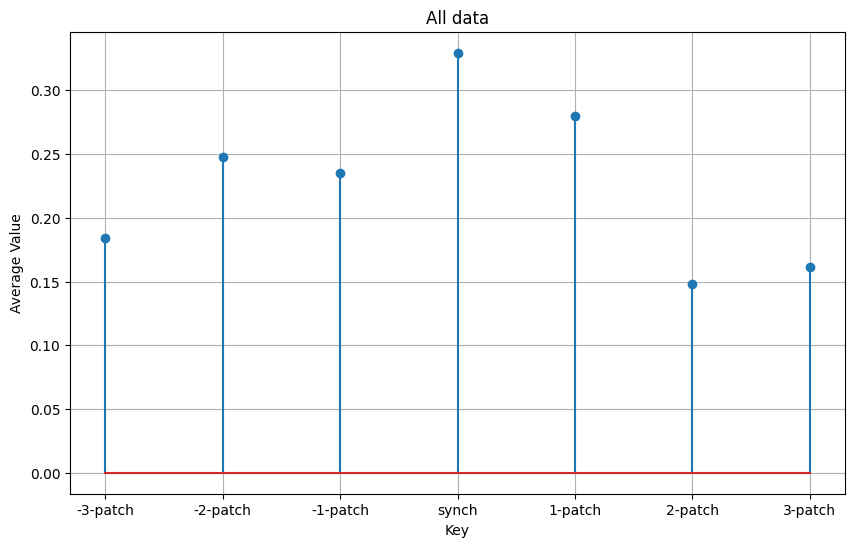

In [33]:

# Calculate averages
averages = {}
for key in sums_counts:
    averages[key] = sums_counts[key]['sum'] / sums_counts[key]['count']

# Prepare the final list in the specified order
final_list_order = ['-3-patch', '-2-patch', '-1-patch', 'synch', '1-patch', '2-patch', '3-patch']
final_list = [averages.get(key, 0) for key in final_list_order]

plt.figure(figsize=(10, 6))
plt.stem(final_list_order, final_list)
plt.title('All data')
plt.xlabel('Key')
plt.ylabel('Average Value')
plt.grid()
plt.show()


In [34]:
dic_to_plot_a

{'0-99': {'0-24': {'synch': 0.41606787,
   '1-patch': 0.18543741,
   '2-patch': 0.27661878,
   '3-patch': 0.1218759},
  '25-49': {'-1-patch': 0.20216079,
   'synch': 0.22499043,
   '1-patch': 0.4505155,
   '2-patch': 0.122333296},
  '50-74': {'-2-patch': 0.29184103,
   '-1-patch': 0.16247995,
   'synch': 0.32140818,
   '1-patch': 0.22427088},
  '75-99': {'-3-patch': 0.15947473,
   '-2-patch': 0.12841225,
   '-1-patch': 0.43995517,
   'synch': 0.27215785}},
 '1-100': {'1-25': {'synch': 0.45202225,
   '1-patch': 0.151121,
   '2-patch': 0.18847562,
   '3-patch': 0.20838116},
  '26-50': {'-1-patch': 0.22849242,
   'synch': 0.21125743,
   '1-patch': 0.38481575,
   '2-patch': 0.17543437},
  '51-75': {'-2-patch': 0.2941948,
   '-1-patch': 0.12249234,
   'synch': 0.25555712,
   '1-patch': 0.32775575},
  '76-100': {'-3-patch': 0.17648783,
   '-2-patch': 0.083040036,
   '-1-patch': 0.35025674,
   'synch': 0.39021537}},
 '2-101': {'2-26': {'synch': 0.3927676,
   '1-patch': 0.27811944,
   '2-patch

In [35]:
# Initialize lists to store the values
values_synch = []
values_1_patch = []
values_2_patch = []
values_3_patch = []
values_1_patch_min = []
values_2_patch_min = []
values_3_patch_min = []

# Iterate over the nested dictionary to extract values
for segment, patches in seg_dict_a.items():
    for patch, details in patches.items():
        if 'synch' in details:
            values_synch.append(details['synch'])
        if '1-patch' in details:
            values_1_patch.append(details['1-patch'])
        if '2-patch' in details:
            values_2_patch.append(details['2-patch'])
        if '3-patch' in details:
            values_3_patch.append(details['3-patch'])
    
        if '-1-patch' in details:
            values_1_patch_min.append(details['-1-patch'])
        if '-2-patch' in details:
            values_2_patch_min.append(details['-2-patch'])
        if '-3-patch' in details:
            values_3_patch_min.append(details['-3-patch'])

In [36]:
len(values_1_patch)

2628

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


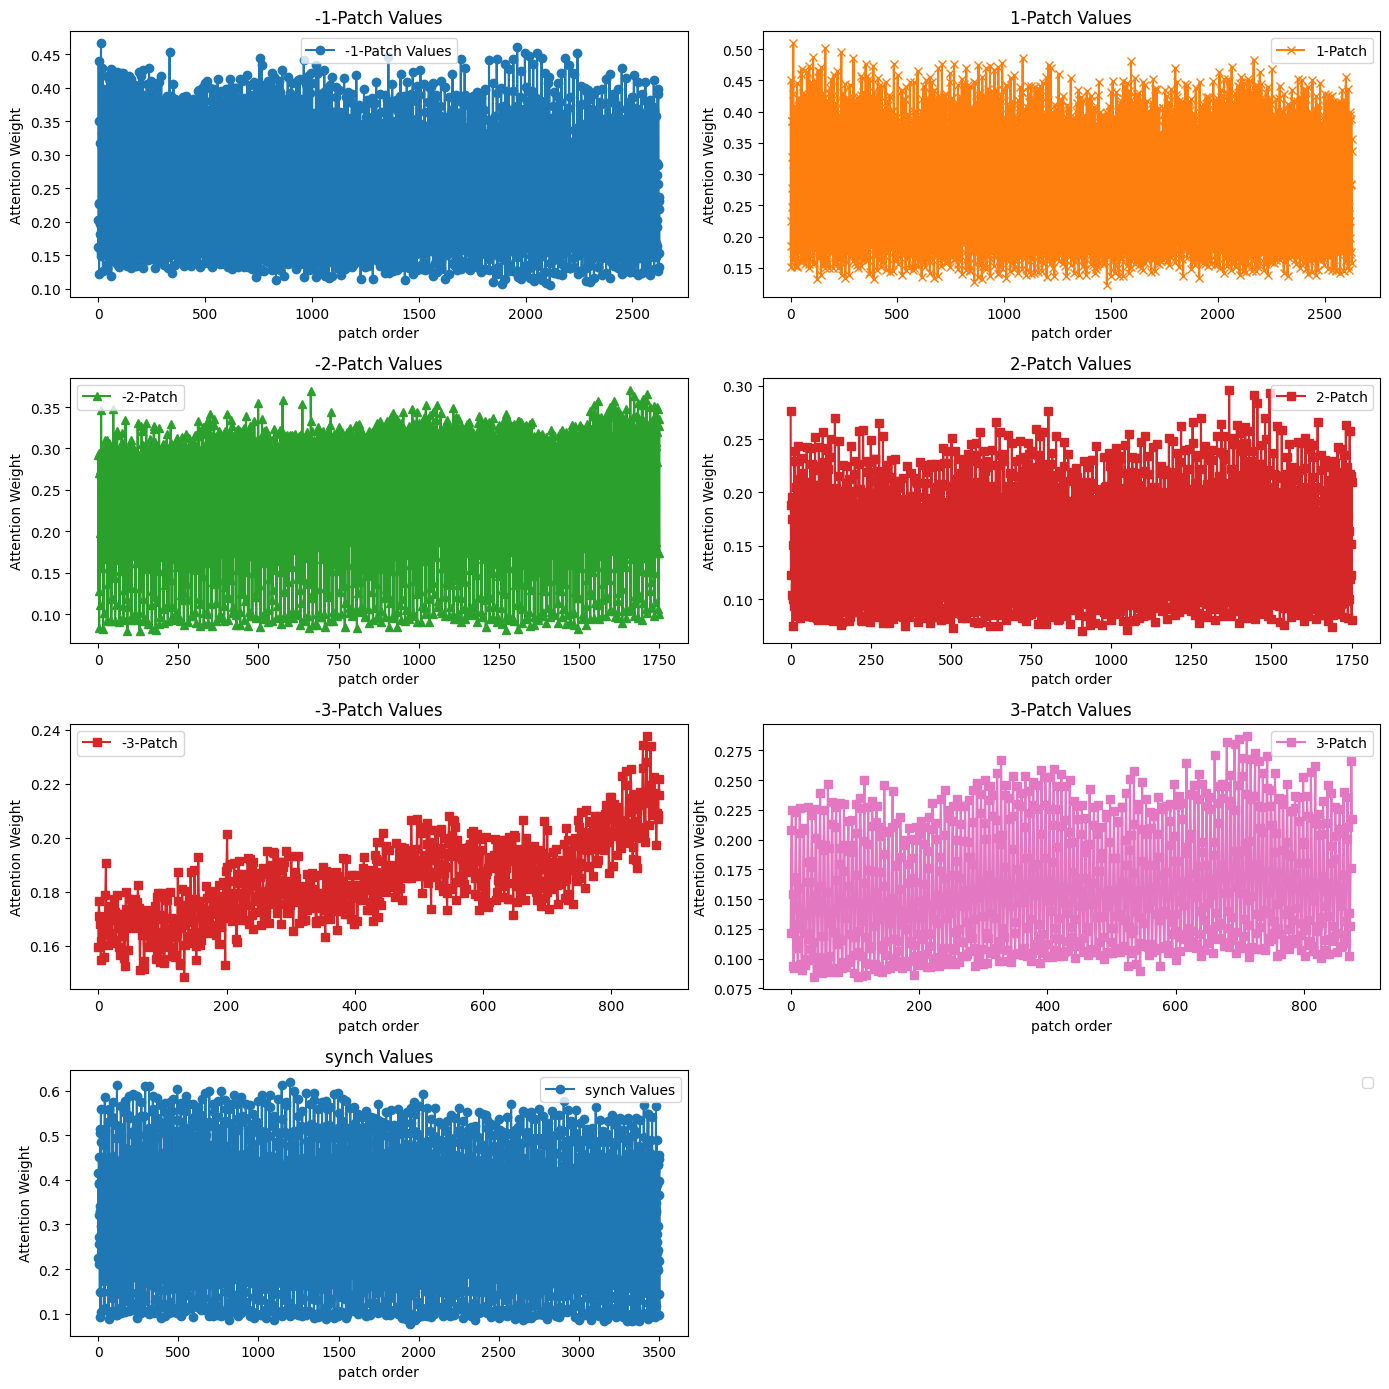

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the 2x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(14, 14))  

# Plotting on each subplot
axs[0, 0].plot(values_1_patch_min, label='-1-Patch Values', marker='o')
axs[0, 0].set_title('-1-Patch Values')

axs[0, 1].plot(values_1_patch, label='1-Patch', marker='x', color='tab:orange')
axs[0, 1].set_title('1-Patch Values')

axs[1, 0].plot(values_2_patch_min, label='-2-Patch', marker='^', color='tab:green')
axs[1, 0].set_title('-2-Patch Values')

axs[1, 1].plot(values_2_patch, label='2-Patch', marker='s', color='tab:red')
axs[1, 1].set_title('2-Patch Values')


axs[2, 0].plot(values_3_patch_min, label='-3-Patch', marker='s', color='tab:red')
axs[2, 0].set_title('-3-Patch Values')

axs[2, 1].plot(values_3_patch, label='3-Patch', marker='s', color='tab:pink')
axs[2, 1].set_title('3-Patch Values')

axs[3, 0].plot(values_synch, label='synch Values', marker='o', color='tab:blue')
axs[3, 0].set_title('synch Values')

axs[3, 1].axis('off')
# Setting labels and legends for all axes
for ax in axs.flat:
    ax.set_xlabel('patch order')
    ax.set_ylabel('Attention Weight')
    ax.legend()



plt.tight_layout()
plt.show()


TypeError: unhashable type: 'dict'

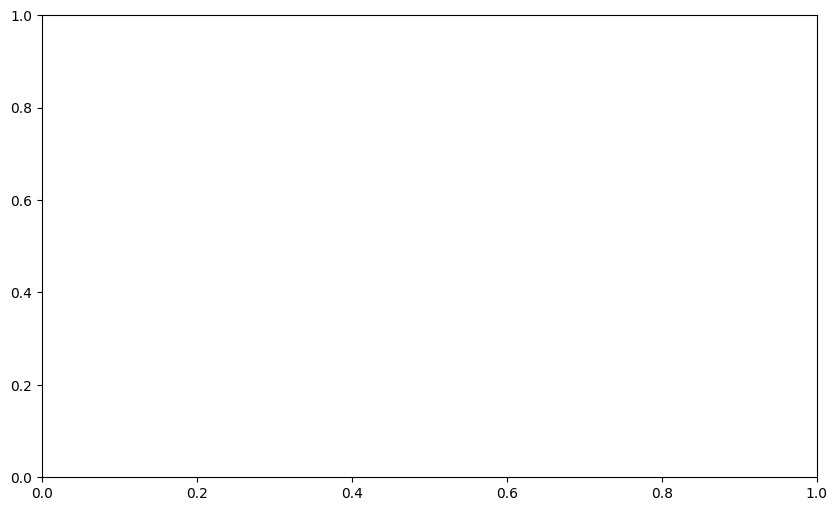

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example segment to plot
segment_key = '0-99'
segment_patches = seg_dict_a[segment_key]

plt.figure(figsize=(10, 6))

# Plotting each patch's attention weights
for patch_key, attention_weights in segment_patches.items():
    plt.plot(attention_weights, label=f'Patch {patch_key}')

plt.title(f'Attention Weights for Segment {segment_key}')
plt.xlabel('Patch Index')
plt.ylabel('Attention Weight')
plt.legend()
plt.show()
segment_patches.items()

TypeError: unhashable type: 'dict'

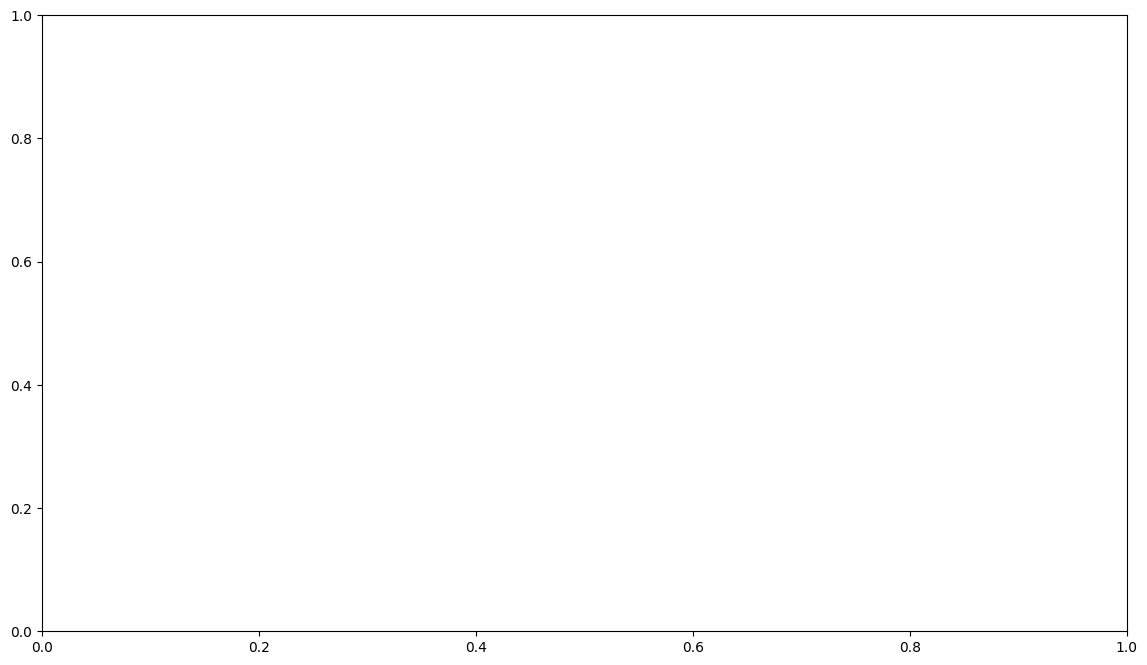

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming seg_dict_a is your nested dictionary structure

plt.figure(figsize=(14, 8))  # Adjust the figure size as needed

# Iterate through all segments in the dictionary
for segment_key, segment_patches in seg_dict_a.items():
    # Plotting each patch's attention weights within this segment
    for patch_key, attention_weights in segment_patches.items():
        plt.plot(attention_weights, label=f'Segment {segment_key} Patch {patch_key}',marker='x')

plt.title('Attention Weights Across All Segments')
plt.xlabel('Patch Index in Target Segment')
plt.ylabel('Attention Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [ ]:
    
for idx in range(0, 19):   
    s_begin = idx * 50
    s_end = s_begin + 100
    r_begin = s_end
    r_end = r_begin + 100
    #r_begin = s_begin
    #r_end = r_begin + self.out_len

    if s_begin + 100 +25 > 1000:
        s_begin =1000 - 100 - 25
        s_end = s_begin + 100
        r_begin = s_end
        r_end = r_begin + 25
    
    
    
    
    

    print(f"{s_begin},{s_end}")

0,100
50,150
100,200
150,250
200,300
250,350
300,400
350,450
400,500
450,550
500,600
550,650
600,700
650,750
700,800
750,850
800,900
850,950
875,975


In [ ]:
tsa_layer_weights[0]['att-A-B'][0, 0, :, :].cpu().numpy()

array([[0.41258198, 0.23277493, 0.16934974, 0.1852933 ],
       [0.15918621, 0.35693496, 0.23439474, 0.24948403],
       [0.21369304, 0.28031063, 0.17733449, 0.32866186],
       [0.1845323 , 0.20698853, 0.37531495, 0.2331642 ]], dtype=float32)

### Attention all batches


In [ ]:

sum_att_A_B = None
sum_att_B_A = None
# Iterate over the list of elements
for element in tsa_layer_weights:
    # For each key in the dictionary ('att-A-B' and 'att-B-A'), sum the matrices
    att_A_B_matrices = element['att-A-B']
    att_B_A_matrices = element['att-B-A']
    
    # Sum for 'att-A-B'
    if sum_att_A_B is None:
        # If this is the first iteration, initialize the sum tensors
        sum_att_A_B = sum(att_A_B_matrices)
    else:
        # Otherwise, add the current list of tensors to the running total
        sum_att_A_B += sum(att_A_B_matrices)
    
    # Sum for 'att-B-A'
    if sum_att_B_A is None:
        sum_att_B_A = sum(att_B_A_matrices)
    else:
        sum_att_B_A += sum(att_B_A_matrices)
 
 

# Min-Max Normalization for sum_att_A_B
min_att_A_B = torch.min(sum_att_A_B)
max_att_A_B = torch.max(sum_att_A_B)
normalized_sum_att_A_B = (sum_att_A_B - min_att_A_B) / (max_att_A_B - min_att_A_B)

# Min-Max Normalization for sum_att_B_A
min_att_B_A = torch.min(sum_att_B_A)
max_att_B_A = torch.max(sum_att_B_A)
normalized_sum_att_B_A = (sum_att_B_A - min_att_B_A) / (max_att_B_A - min_att_B_A)


 
sum_tot = normalized_sum_att_B_A.T + normalized_sum_att_A_B   
# Min-Max Normalization for sum_tot
min_att_tot = torch.min(sum_tot)
max_att_tot= torch.max(sum_tot)
normalized_sum_att_tot= (sum_tot - min_att_tot) / (max_att_tot - min_att_tot)




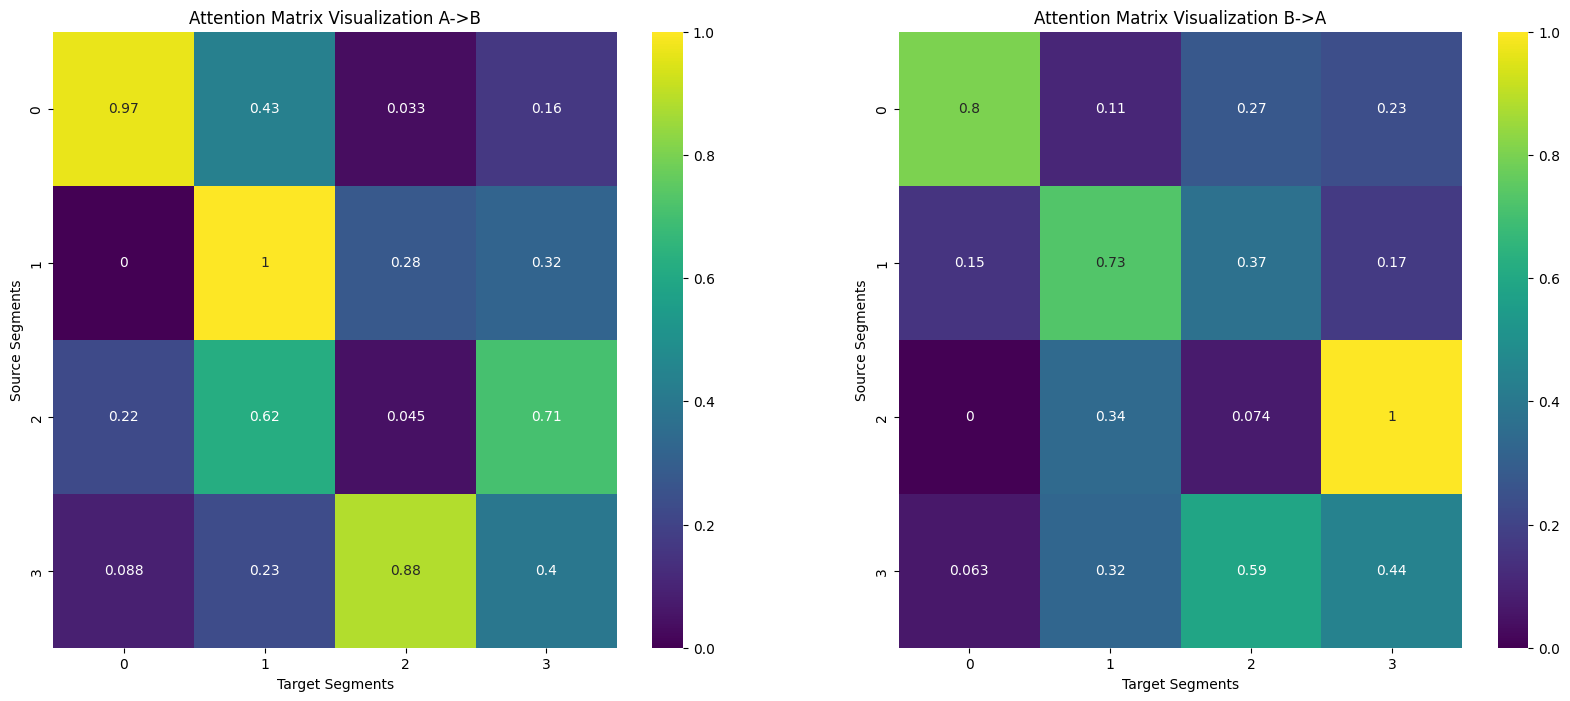

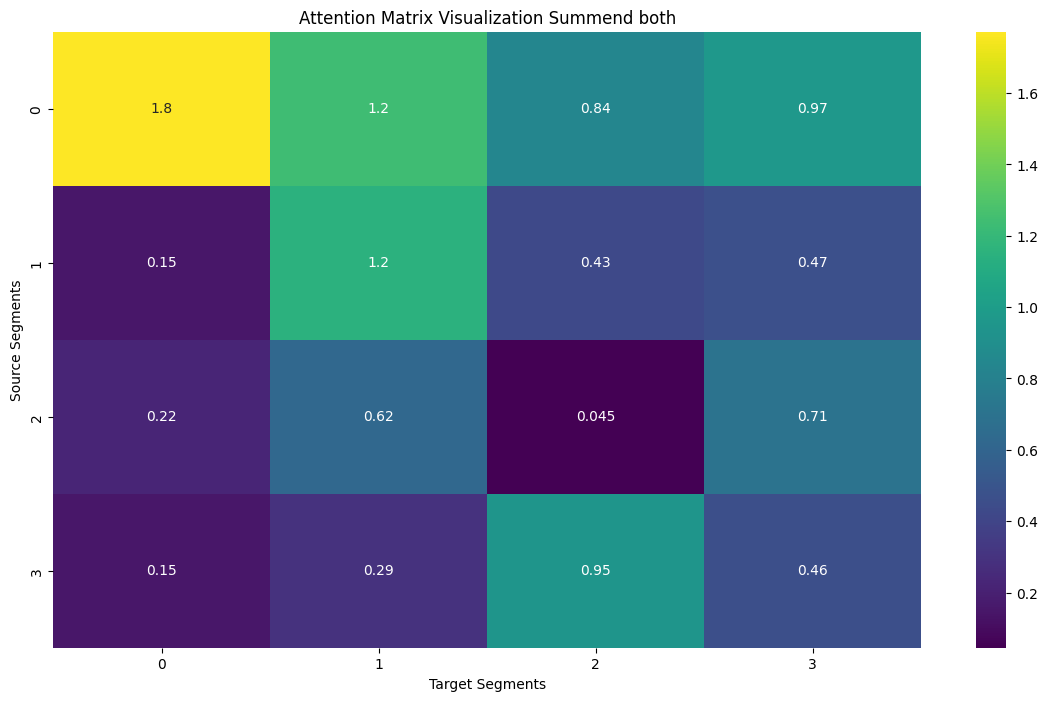

In [ ]:

plt.figure(figsize=(20, 8))  # Adjust the figure size as needed

# Plot for attention_matrix_send
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(normalized_sum_att_A_B[0], annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization A->B')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')

# Plot for attention_matrix_receive
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(normalized_sum_att_B_A[0], annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization B->A')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')


plt.figure(figsize=(14, 8))

# Visualization
sns.heatmap(sum_tot[0], annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization Summend both')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')


plt.show()


### Graphs for time 

In [ ]:
import plotly.graph_objects as go

 

### One batch

"# Visualization\nplt.subplot(1, 4, 4) \nsns.heatmap(dec_attn, annot=True, cmap='viridis')\nplt.title('Attention Matrix Visualization decoder')\nplt.xlabel('Target Segments')\nplt.ylabel('Source Segments')\n\nplt.show()"

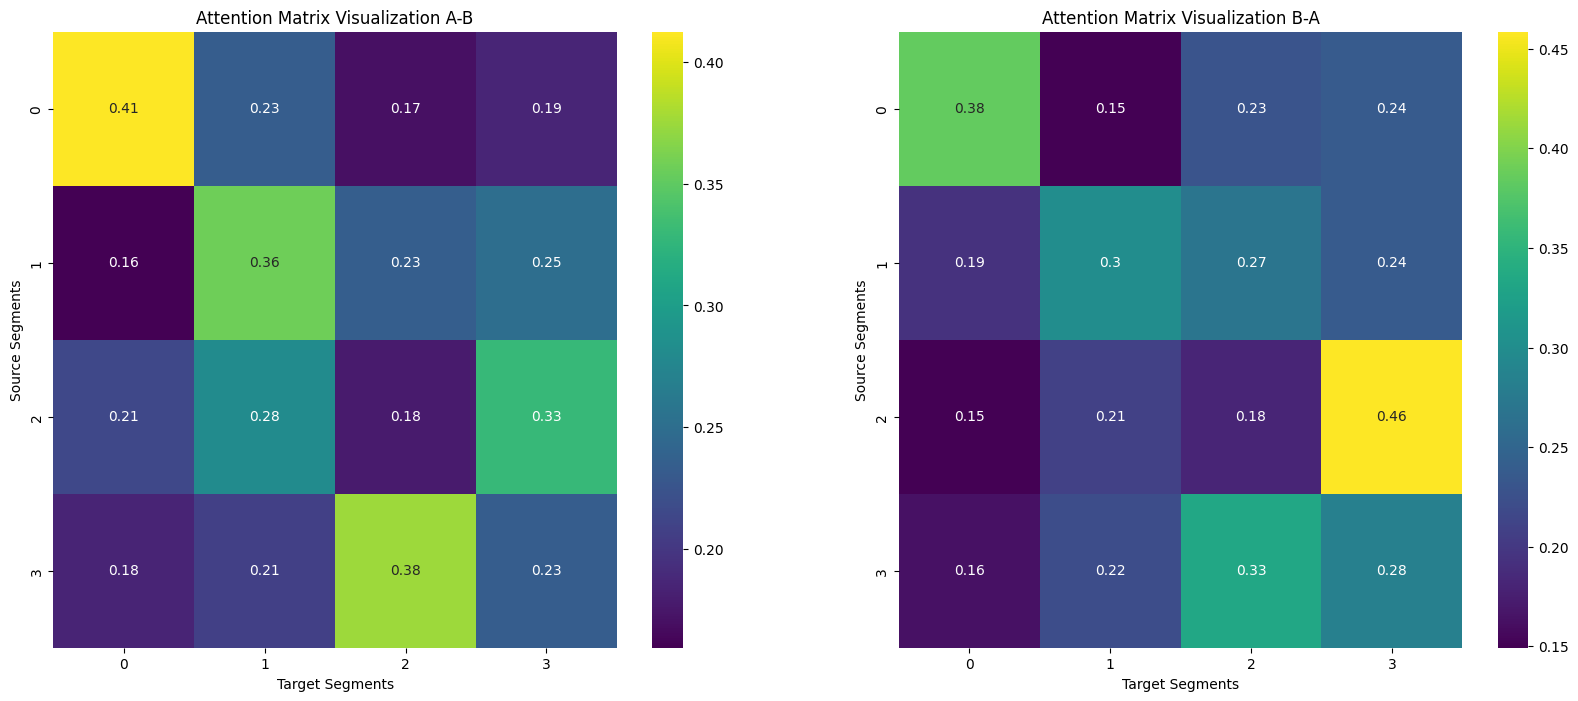

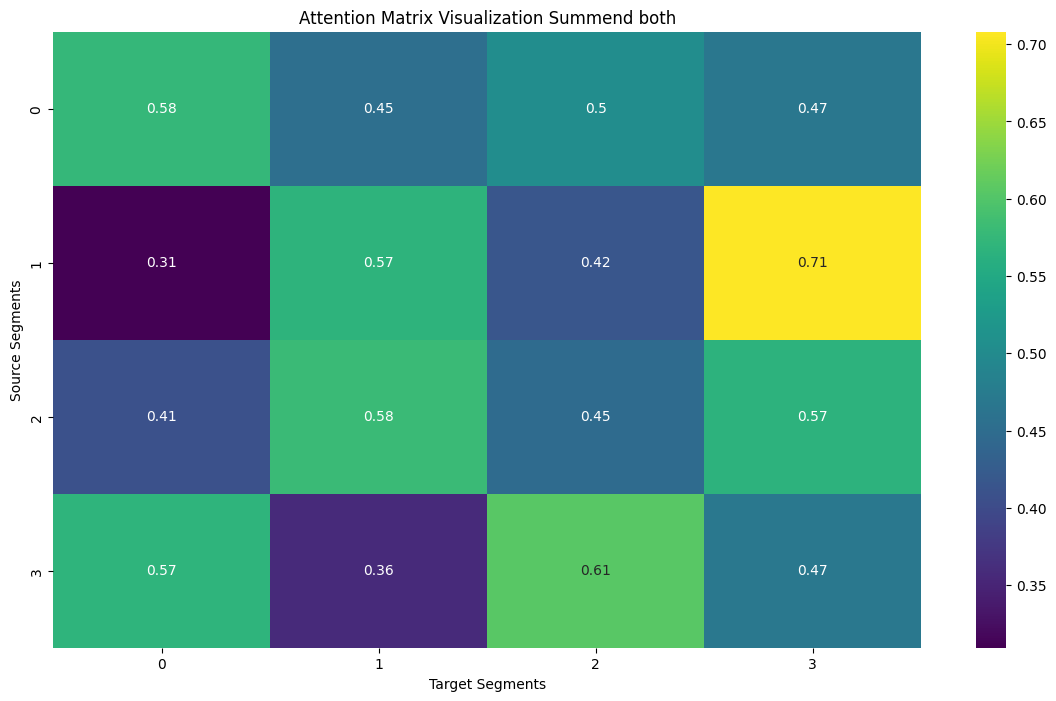

In [ ]:

attention_matrix_A_B = tsa_layer_weights[0]['att-A-B'][0, 0, :, :].cpu().numpy()
attention_matrix_B_A= tsa_layer_weights[0]['att-B-A'][0, 0, :, :].cpu().numpy()
att_plus_both = attention_matrix_A_B + np.flipud(attention_matrix_B_A)
#dec_attn = dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()


plt.figure(figsize=(20, 8))

# Visualization
plt.subplot(1, 2, 1) 
sns.heatmap(attention_matrix_A_B, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization A-B')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')



# Visualization
plt.subplot(1, 2, 2) 
sns.heatmap(attention_matrix_B_A, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization B-A')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')

plt.figure(figsize=(14, 8))

# Visualization
sns.heatmap(att_plus_both, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization Summend both')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')



"""# Visualization
plt.subplot(1, 4, 4) 
sns.heatmap(dec_attn, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization decoder')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')

plt.show()"""

### Graph based on attnetion

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_directed_attention_graph(attention_matrix, title):
    """
    Creates and plots a directed graph from an attention matrix with source nodes on one side and target nodes on the other.
    attention_matrix: A squared numpy array representing attention weights.
    title: The title for the plot.
    """
    G = nx.DiGraph()
    num_segments = attention_matrix.shape[0]

    # Node positions
    pos = {}
    # Labels and colors for nodes
    node_labels = {}
    node_colors = []

    # Define positions for source nodes (left) and target nodes (right)
    for i in range(num_segments):
        pos[f'S{i+1}'] = np.array([-1, -i])
        pos[f'T{i+1}'] = np.array([1, -i])
        node_labels[f'S{i+1}'] = f'S{i+1}'
        node_labels[f'T{i+1}'] = f'T{i+1}'
        node_colors.extend(['lightblue', 'lightgreen'])

    # Add nodes to the graph
    for node in pos:
        G.add_node(node)

    # Add edges with weights
    for i in range(num_segments):
        for j in range(num_segments):
            if attention_matrix[i, j] > 0.2:  # Apply threshold to simplify the graph
                G.add_edge(f'S{i+1}', f'T{j+1}', weight=round(attention_matrix[i, j], 2))

    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Draw the graph
    nx.draw(G, pos, labels=node_labels, node_color=node_colors, with_labels=True,
            edge_color='k', linewidths=1, font_size=12, arrows=True, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()



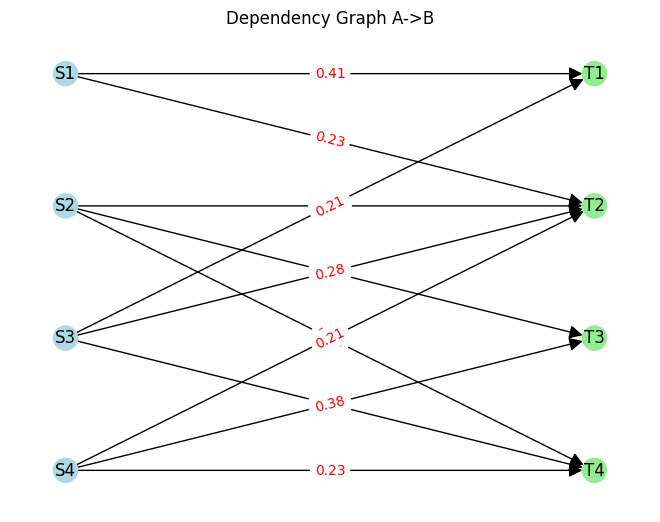

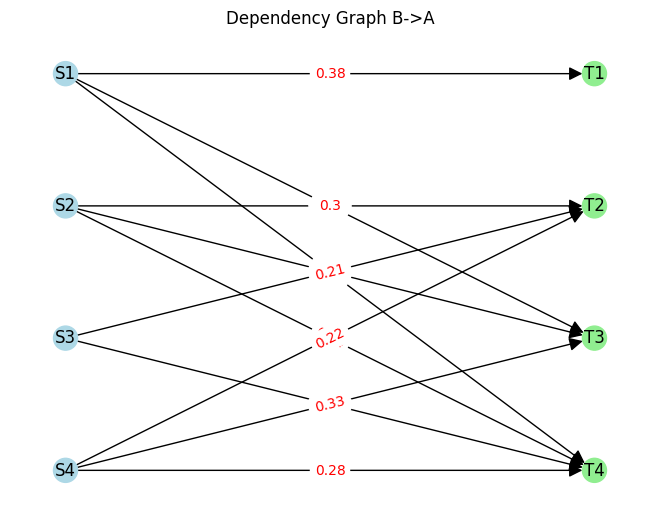

In [ ]:
plot_directed_attention_graph(attention_matrix_A_B, "Dependency Graph A->B")
plot_directed_attention_graph(attention_matrix_B_A, "Dependency Graph B->A")

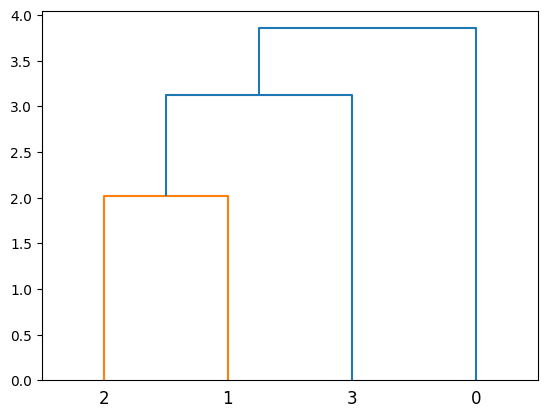

In [ ]:
from scipy.stats import zscore

# Assuming `attention_values` is a 2D array of attention scores between segments
# Each row corresponds to a query segment, and each column corresponds to a key segment
z_scores = zscore(all_a_b[8], axis=None)
from scipy.cluster.hierarchy import dendrogram, linkage

# Using 'ward' linkage method as an example; explore others like 'average', 'complete'
linked = linkage(z_scores, 'ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()


In [ ]:

model_synt.eval()
total_loss = 0
count = 0
preds =[]
with torch.no_grad():  
    for batch_idx, (inputs, targets) in enumerate(data_loader_train_synth):
        predictions = model_synt(inputs.float())  # Get model predictions
        
        predictions  = (predictions).numpy()
        
        preds.append(predictions)
# Example plot for the first signal in the batch


0,100
50,150
100,200
150,250
200,300
250,350
300,400
350,450
400,500
450,550
500,600
550,650
600,700
650,750
700,800
750,850
800,900
850,950


AttributeError: Line2D.set() got an unexpected keyword argument 'line'

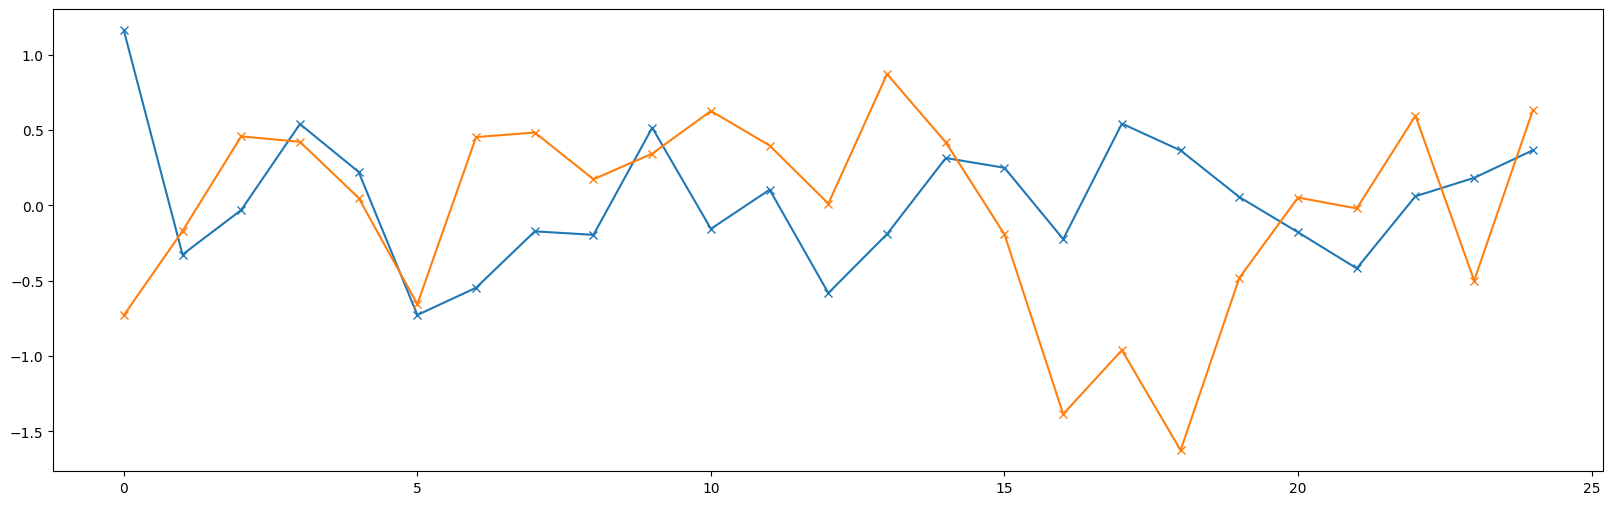

In [ ]:
from utils.Metrics import *

plt.figure(figsize=(20, 6))
plt.plot(preds[0][0][:,0], label='Predictions', marker='x') 
plt.plot(preds[0][0][:,1], label='Predictions', marker='x') 
plt.plot(signal_1[0:100], label=' ground truth', marker='o', line="--")
plt.legend()
plt.title('Model Predictions vs. True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

MSE(preds[0][0][:,0],signal_1[0:100])


## Crosscorrelation


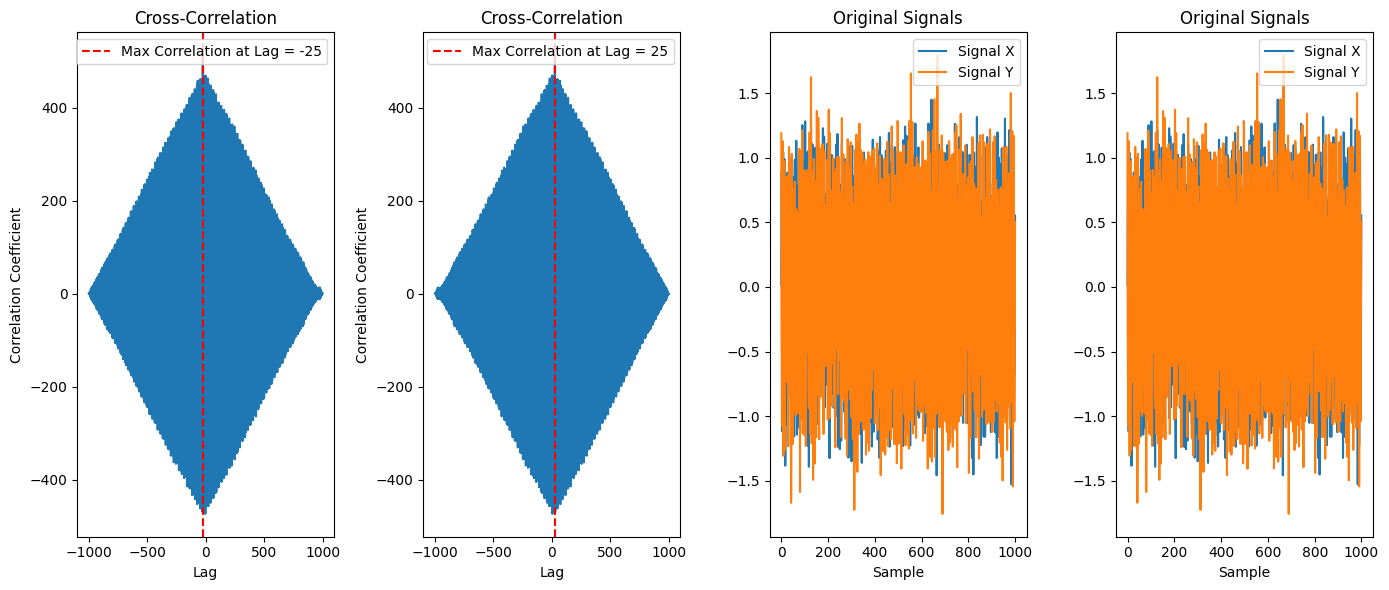

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = signal_1
y = signal_2

cross_corr1 = np.correlate(x, y, mode='full')
cross_corr2 = np.correlate(y, x, mode='full')

# Find the lag with the maximum correlation
lags1 = np.arange(-len(x) + 1, len(y))
max_lag1 = lags1[np.argmax(cross_corr1)]

lags2 = np.arange(-len(x) + 1, len(y))
max_lag2 = lags2[np.argmax(cross_corr2)]

# Plotting
plt.figure(figsize=(14, 6))

# Cross-correlation plot
plt.subplot(1, 4, 1)
plt.plot(lags1, cross_corr1)
plt.title('Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.axvline(max_lag1, color='r', linestyle='--', label=f'Max Correlation at Lag = {max_lag1}')
plt.legend()


plt.subplot(1, 4, 2)
plt.plot(lags2, cross_corr2)
plt.title('Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.axvline(max_lag2, color='r', linestyle='--', label=f'Max Correlation at Lag = {max_lag2}')
plt.legend()

# Original signals for reference
plt.subplot(1, 4, 3)
plt.plot(x, label='Signal X')
plt.plot(y, label='Signal Y')
plt.title('Original Signals')
plt.xlabel('Sample')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(x, label='Signal X')
plt.plot(y, label='Signal Y')
plt.title('Original Signals')
plt.xlabel('Sample')
plt.legend()


plt.tight_layout()
plt.show()




## Experiment 